In [1]:
import numpy as np
import pandas as pd 

Visualize the data 

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [2]:
Sentiment_dict = {0 : 'negative' , 1 : 'somewhat negative' , 2 : 'neutral' ,
                  3 : 'somewhat positive' , 4 : 'positive'}

In [3]:
Train_Df = pd.read_csv("train.tsv" , sep = '\t')

Train_Df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print(Train_Df.columns)

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')


In [5]:
Reviews = Train_Df['Phrase']
Sentiments = Train_Df['Sentiment']

print(len(Reviews))

rand_int = np.random.choice(len(Reviews))

print(Reviews[rand_int])
print(Sentiments[rand_int])

156060
weighs no more
2


In [6]:
Test_Df = pd.read_csv("test.tsv" , sep = '\t')

Test_Df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


Creating the data

In [11]:
from __future__ import print_function, division
from builtins import range

import nltk
import numpy as np
from sklearn.utils import shuffle

from nltk.stem import WordNetLemmatizer

import re
from tqdm import tqdm

In [12]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

In [15]:
wordnet_lemmatizer = WordNetLemmatizer()

def Process_Sentences(Reviews):
    Processed_Reviews = []
    
    for sent in tqdm(Reviews) :
        sent = sent.lower()
        sent = re.sub("[^a-zA-Z]"," ", sent) # remove all non alphabetic characters
        tokens = nltk.tokenize.word_tokenize(sent) # split string into words (tokens)
        tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
        tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
        tokens = [t for t in tokens if t not in stopwords] # remove stopwords
        
        Processed_Reviews.append(tokens)
    return Processed_Reviews

Train_Reviews = Process_Sentences(Train_Df['Phrase'])
Test_Reviews = Process_Sentences(Test_Df['Phrase'])

print(len(Train_Reviews))
print(len(Test_Reviews))

100%|██████████| 66292/66292 [00:14<00:00, 4442.84it/s]

156060
66292


Creating the model

In [18]:
import tensorflow as tf 
keras = tf.keras 

In [27]:
from tensorflow.keras.utils import to_categorical
import random
from tensorflow import set_random_seed

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [21]:
Y = to_categorical(Sentiments)

print(Y.shape)

(156060, 5)


In [28]:
# Finding the max unique words 

maxi_size = -np.Inf
Unique_words = set()

for review in Train_Reviews :
    pure_review = set(review)
    size = len(pure_review)
    
    Unique_words.update(pure_review)
    
    if size > maxi_size :
        maxi_size = size 

print(maxi_size)
print(len(Unique_words))

26
13325


In [25]:
from sklearn.model_selection import train_test_split 

Xtrain , Xtest , Ytrain , Ytest = train_test_split(Train_Reviews , Y , test_size = 0.2 , random_state = 2)

print(len(Xtrain))
print(len(Xtest))

print(Ytrain.shape)
print(Ytest.shape)

assert len(Xtrain) == len(Ytrain)
assert len(Xtest) == len(Ytest)

124848
31212
(124848, 5)
(31212, 5)


In [29]:
tokenizer = Tokenizer(num_words=len(Unique_words))
tokenizer.fit_on_texts(list(Xtrain))

Xtrain = tokenizer.texts_to_sequences(Xtrain)
Xtest = tokenizer.texts_to_sequences(Xtest)

Xtrain = sequence.pad_sequences(Xtrain, maxlen=maxi_size)
Xtest = sequence.pad_sequences(Xtest, maxlen=maxi_size)

print(Xtrain.shape)
print(Xtest.shape)

print(Ytrain.shape)
print(Ytest.shape)

(124848, 26)
(31212, 26)
(124848, 5)
(31212, 5)


In [35]:
model=Sequential()

model.add(Embedding(len(Unique_words) , 300 , input_length = maxi_size))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 300)           3997500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 26, 128)           219648    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,273,561
Trainable params: 4,273,561
Non-trainable params: 0
_________________________________________________________________


In [36]:
r = model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest),epochs=10, batch_size=256, verbose=1)

/opt/DL/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 90s 723us/step - loss: 1.1838 - acc: 0.5268 - val_loss: 1.1067 - val_acc: 0.5537
Epoch 2/10
124848/124848 [==============================] - 86s 691us/step - loss: 1.0680 - acc: 0.5781 - val_loss: 1.0153 - val_acc: 0.6020
Epoch 3/10
124848/124848 [==============================] - 87s 697us/step - loss: 0.9767 - acc: 0.6177 - val_loss: 0.9525 - val_acc: 0.6195
Epoch 4/10
124848/124848 [==============================] - 86s 688us/step - loss: 0.9223 - acc: 0.6357 - val_loss: 0.9285 - val_acc: 0.6253
Epoch 5/10
124848/124848 [==============================] - 87s 698us/step - loss: 0.8908 - acc: 0.6445 - val_loss: 0.9146 - val_acc: 0.6295
Epoch 6/10
124848/124848 [==============================] - 87s 697us/step - loss: 0.8682 - acc: 0.6519 - val_loss: 0.9194 - val_acc: 0.6337
Epoch 7/10
124848/124848 [==============================] - 87s 696us/step - loss: 0.8508 - acc: 0.6565

NameError: name 'plt' is not defined

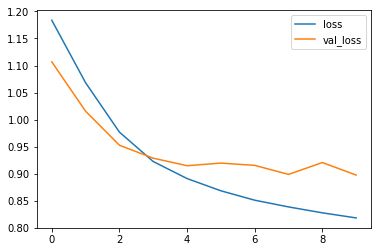

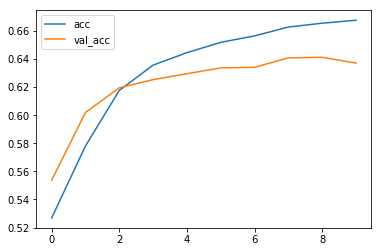

In [38]:
import matplotlib.pyplot as plt 

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [39]:
# Saving Model and weights 

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [40]:
model.save_weights("model.h5")